In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df = pd.read_excel("BaseFeaturesDE.xlsx")
df = df.drop('Unnamed: 0', axis = 1)


In [3]:
lagNumberStart = 1
lagNumberEnd = 8

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['DE Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
    
X = df[feature_cols].copy() #input features for fitting

size = -int(len(df)*0.2)

Xinput = df.iloc[:size]
Xtest = df.iloc[size:] # 20%

size2 = -int(len(Xinput)*0.25)

Xtrain = Xinput.iloc[:size2].copy() #60%
Xvalidate = Xinput.iloc[size2:].copy() #20%

trainX = Xtrain[feature_cols] # Features
trainy = Xtrain['DE Electricity (kWh)'] # Target variable

validateX = Xvalidate[feature_cols] # Features
validatey = Xvalidate['DE Electricity (kWh)'] # Target variable

testX = Xtest[feature_cols] # Features
testy = Xtest['DE Electricity (kWh)'] # Target variable

inputX = Xinput[feature_cols] # Features
inputy = Xinput['DE Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
scaler.fit(X)
trainXscaled = scaler.transform(trainX)
validateXscaled = scaler.transform(validateX)
testXscaled = scaler.transform(testX)
inputXscaled = scaler.transform(inputX)

2.8729771423771666


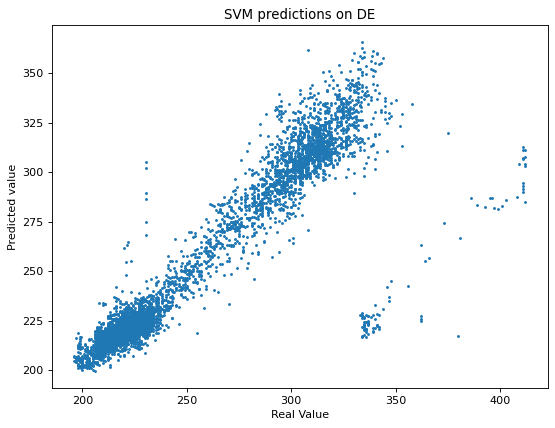

In [4]:
estimator = svm.SVR(C = 100,  kernel = 'rbf', epsilon = 1).fit(inputXscaled, inputy)
y_pred = estimator.predict(testXscaled)

SVMMAPE = mean_absolute_percentage_error(testy, y_pred) * 100
print(SVMMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(testy,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('SVM predictions on DE')
# Display a figure.
plt.show()

# 4. Shapley

In [5]:
import shap
shap.initjs()

In [6]:
# The SHAP values
shapsamples = shap.sample(testXscaled,100)
explainer = shap.KernelExplainer(estimator.predict, shapsamples)
shap_values = explainer.shap_values(shapsamples)



  0%|          | 0/100 [00:00<?, ?it/s]

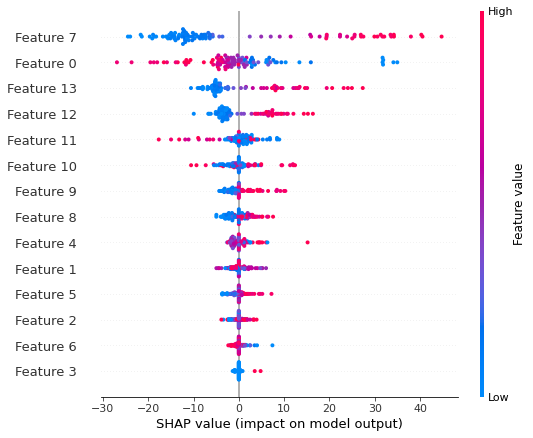

In [7]:
shap.summary_plot(shap_values, shapsamples)



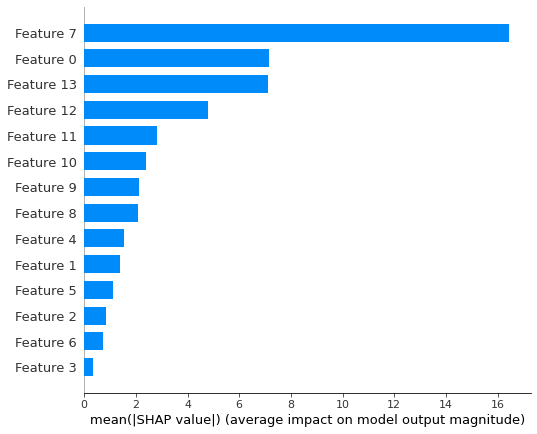

In [8]:
shap.summary_plot(shap_values, shapsamples, plot_type='bar')

In [12]:
testX.head()

,dayofweek,hour,month,holiday,Temperature (C),Feels like (C),Humidity (%),n-48.,n-96.,n-144.,n-192.,n-240.,n-288.,n-336.
28109,4,14.5,8,0,19.6,19.6,86.00,17.62,17.81,17.19,16.88,11.00,10.50,19.62
28110,4,15.0,8,0,19.5,19.5,85.86,16.69,17.00,17.56,16.94,11.12,10.50,19.38
28111,4,15.5,8,0,19.5,19.5,85.86,17.19,17.62,18.12,17.69,11.19,10.12,17.69
28112,4,16.0,8,0,19.1,19.1,86.70,16.94,17.75,16.88,17.88,10.94,10.50,16.31
28113,4,16.5,8,0,19.1,19.1,86.70,17.25,17.25,17.25,17.81,11.50,10.31,15.19


Holiday

# due to lack of data for holiday Im trying to rerun an explainer for specific points

In [52]:
shapsamples2 = shap.sample(testXscaled[5376:5380],4)
explainer = shap.KernelExplainer(estimator.predict, shapsamples2)
shap_values2 = explainer.shap_values(shapsamples2)

shapsamples2

#explainer = shap.KernelExplainer(estimator.predict, testXscaled)
#holidayvalues=testXscaled[5378]
#shapholiday = explainer.explain(holidayvalues)
#holidayvalues



  0%|          | 0/4 [00:00<?, ?it/s]

array([[-0.49964766, -0.03679446,  1.4378495 ,  6.95583788, -1.13941437,
        -1.05587951,  0.54035142,  0.37313026,  0.37638905, -0.79682125,
        -0.73581871,  0.51607729,  0.53214598,  0.54717965],
       [-0.49964766,  0.03539608,  1.4378495 ,  6.95583788, -0.8394093 ,
        -0.75864603, -0.02234031,  0.3575131 ,  0.37638905, -0.82810192,
        -0.79838627,  0.46916508,  0.51651385,  0.57843563],
       [-0.49964766,  0.10758662,  1.4378495 ,  6.95583788, -0.8394093 ,
        -0.75864603, -0.02234031,  0.3575131 ,  0.36075139, -0.81246159,
        -0.78274438,  0.5473521 ,  0.57904237,  0.4846677 ],
       [-0.49964766,  0.17977716,  1.4378495 ,  6.95583788, -0.69823045,
        -0.58030593, -0.47621633,  0.37313026,  0.3920267 , -0.81246159,
        -0.82967005,  0.5473521 ,  0.57904237,  1.17229919]])

In [58]:
unscaled2 = scaler.inverse_transform(testXscaled[5376:5380])
i = 3
shap.force_plot(explainer.expected_value, shap_values2[i], features=unscaled2[i], feature_names=inputX.columns)

# This didnt work so i give up on holiday plots

In [18]:
i = 85
shap.force_plot(explainer.expected_value, shap_values[i], features=unscaled[i], feature_names=inputX.columns)


In [20]:
i = 39
shap.force_plot(explainer.expected_value, shap_values[i], features=unscaled[i], feature_names=inputX.columns)


Wednesday

In [22]:
i = 48
shap.force_plot(explainer.expected_value, shap_values[i], features=unscaled[i], feature_names=inputX.columns)


Weekend

In [24]:
i = 19
shap.force_plot(explainer.expected_value, shap_values[i], features=unscaled[i], feature_names=inputX.columns)

In [28]:
i = 66
shap.force_plot(explainer.expected_value, shap_values[i], features=unscaled[i], feature_names=inputX.columns)

In [29]:
unscaled = scaler.inverse_transform(shapsamples)
shapdf = pd.DataFrame(unscaled, columns=testX.columns)
shapdf[shapdf['Feels like (C)']>20]


,dayofweek,hour,month,holiday,Temperature (C),Feels like (C),Humidity (%),n-48.,n-96.,n-144.,n-192.,n-240.,n-288.,n-336.
15,6.0,16.0,9.0,0.0,22.2,22.2,63.58,218.0,330.0,346.1,326.0,325.0,314.0,220.0
93,5.0,11.5,9.0,0.0,20.3,20.3,57.93,313.0,329.0,328.0,337.0,340.0,219.0,216.0


In [32]:
i = 15
shap.force_plot(explainer.expected_value, shap_values[i], features=unscaled[i], feature_names=inputX.columns)